<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

# Worksheet 4: Feature Engineering - Answers
This worksheet covers concepts covered in the first part of the Feature Engineering module.  It should take no more than 30-40 minutes to complete.  Please raise your hand if you get stuck.  

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (https://matplotlib.org/)
* Seaborn (https://seaborn.pydata.org)
* YData Profiling: (https://ydata-profiling.ydata.ai/docs/master/index.html)

In [27]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re
from ydata_profiling import ProfileReport
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "FutureWarning")

DATA_HOME = '../data/'

## Feature Engineering

This worksheet is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA). We will walk you through the process of transforming raw domain strings to Machine Learning features and creating a decision tree classifer which you will use to determine whether a given domain is legit or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model.  

Overview 2 main steps:

1. **Feature Engineering** - from raw domain strings to numeric Machine Learning features using DataFrame manipulations
2. **Machine Learning Classification** - predict whether a domain is legit or not using a Decision Tree Classifier


  

**DGA - Background**

"Various families of malware use domain generation
algorithms (DGAs) to generate a large number of pseudo-random
domain names to connect to a command and control (C2) server.
In order to block DGA C2 traffic, security organizations must
first discover the algorithm by reverse engineering malware
samples, then generate a list of domains for a given seed. The
domains are then either preregistered, sink-holed or published
in a DNS blacklist. This process is not only tedious, but can
be readily circumvented by malware authors. An alternative
approach to stop malware from using DGAs is to intercept DNS
queries on a network and predict whether domains are DGA
generated. Much of the previous work in DGA detection is based
on finding groupings of like domains and using their statistical
properties to determine if they are DGA generated. However,
these techniques are run over large time windows and cannot be
used for real-time detection and prevention. In addition, many of
these techniques also use contextual information such as passive
DNS and aggregations of all NXDomains throughout a network.
Such requirements are not only costly to integrate, they may not
be possible due to real-world constraints of many systems (such
as endpoint detection). An alternative to these systems is a much
harder problem: detect DGA generation on a per domain basis
with no information except for the domain name. Previous work
to solve this harder problem exhibits poor performance and many
of these systems rely heavily on manual creation of features;
a time consuming process that can easily be circumvented by
malware authors..."    
[Citation: Woodbridge et. al 2016: "Predicting Domain Generation Algorithms with Long Short-Term Memory Networks"]

A better alternative for real-world deployment would be to use "featureless deep learning" - We have a separate notebook where you can see how this can be implemented!(https://www.elastic.co/blog/using-deep-learning-detect-dgas, https://github.com/endgameinc/dga_predict)

**However, let's learn the basics first!!!**


## Load Data

In [2]:
## Load data
full_df = pd.read_csv('../data/dga_data_small.csv')
full_df.head()

,isDGA,domain,host,subclass
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga
2,dga,thenrest,thenrest.net,nivdort
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga


In [3]:
full_df.drop(['host', 'subclass'], axis='columns', inplace=True)
print("(Total Rows, Total Cols)")
print(full_df.shape)

(Total Rows, Total Cols)
(2000, 2)


In [4]:
# print a random sample of the DataFrame
full_df.sample(5).head() 

,isDGA,domain
1109,legit,viralnewsworld
1871,legit,tahrirnews
665,dga,lfgbqjuogwgb
86,dga,itohetciikjqpcmjfhqjrxcijr
314,dga,oywjwmkuygwh


In [5]:
# print a sample of dga domains via filtering
full_df[full_df.isDGA == 'dga'].sample(5)

,isDGA,domain
466,dga,withnews
684,dga,gaqoukusbemvsxsobyheizsgxkj
633,dga,knowwore
939,dga,eoimdeeoakrnabk
967,dga,fsnyamqxbsbp


## Part 1 - Feature Engineering

Option 1 to derive Machine Learning features is to manually hand-craft useful contextual information of the domain string. An alternative approach (not covered in this notebook) is "Featureless Deep Learning", where an embedding layer takes care of deriving features - a huge step towards more "AI".

Previous academic research has focused on the following features that are based on contextual information:

**List of features**:

1. Length ["length"]
2. Number of digits ["digits"]
3. Entropy ["entropy"] - use ```H_entropy``` function provided 
4. Vowel to consonant ratio ["vowel-cons"] - use ```vowel_consonant_ratio``` function provided
5. The index of the first digit - use the ``firstDigitIndex`` function provided
5. N-grams ["n-grams"] - use ```ngram``` functions provided

**Tasks**:    
Split into A and B parts, see below...


Please run the following function cell and then continue reading the next markdown cell with more details on how to derive those features. Have fun!

In [6]:
def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def firstDigitIndex(s):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

### Tasks - A - Feature Engineering

Please try to derive a new pandas 2D DataFrame with a new column for each of feature. Focus on 
1. Length ["length"]
2. Number of digits ["digits"]
3. Entropy ["entropy"] - use ```H_entropy``` function provided 
4. Vowel to consonant ratio ["vowel-cons"] - use ```vowel_consonant_ratio``` function provided
5. The index of the first digit - use the ``firstDigitIndex`` function provided

[pandas.Series.str](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html#pandas.Series.str), [pandas.Series.replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) and [pandas.Series,apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html) can be very helpful to quickly derive those features. Functions you need to apply here are provided in above cell.

In [7]:
# derive features
full_df['length'] = full_df['domain'].str.len()
full_df['digits'] = full_df['domain'].str.count('[0-9]')
full_df['entropy'] = full_df['domain'].apply(H_entropy)
full_df['vowel-cons'] = full_df['domain'].apply(vowel_consonant_ratio)
full_df['firstDigitIndex'] = full_df['domain'].apply(firstDigitIndex)

print(full_df['isDGA'].value_counts())

# check intermediate 2D pandas DataFrame
full_df.sample(n=5).head()


isDGA
dga      1000
legit    1000
Name: count, dtype: int64


,isDGA,domain,length,digits,entropy,vowel-cons,firstDigitIndex
617,dga,1yjm9lf1qwhr9m2bpdtlvsapzj,26,5,4.238901,0.050000,1
884,dga,jisrkqwvoxxxu,13,0,3.334679,0.300000,0
1100,legit,mediavacances,13,0,3.026987,0.857143,0
613,dga,l76tk210vws5v1m7vl7g19iiot8,27,12,4.004344,0.250000,2
324,dga,dxruthbg,8,0,3.000000,0.142857,0


### Tasks - B - Feature Engineering

Finally, let's tackle the **ngram** feature. There are multiple steps involved to derive this feature. Here in this notebook, we use an implementation outlined in the this academic paper [Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence" - see section: Linguistic Features](https://seclab.cs.ucsb.edu/files/publications/Schiavoni2014Phoenix_DGA-Based.pdf).


- **What are ngrams???** Imagine a string like 'facebook', if I were to derive all n-grams for n=2 (aka bi-grams) I would get '['fa', 'ac', 'ce', 'eb', 'bo', 'oo', 'ok']', so you see that you slide with one step from the left and just group 2 characters together each time, a tri-gram for 'facebook' would yielfd '['fac', 'ace', 'ceb', 'ebo', 'boo', 'ook']'. Ngrams have a long history in natural language processing, but are also used a lot for example in detecting malicious executable (raw byte ngrams in this case).

Steps involved:

1. We have the 10000 most common english words (see data file we loaded, we call this DataFrame ```top_en_words```). Now we run the ```ngrams``` functions on a list of all these words. The output here is a list that contains ALL 1-grams, bi-grams and tri-grams of these 10000 most common english words.
2. We used the ```Counter``` function from collections to derive a dictionary ```ngram_common_dict``` that contains the counts of all unique 1-grams, bi-grams and tri-grams.
3. Our ```ngram_feature``` function will do the core magic. It takes your domain as input, splits it into ngrams (n is a function parameter) and then looks up these ngrams in the english dictionary ```ngram_common_dict```. Function returns the normalized sum of all ngrams that were contained in the english dictionary. For example, running ```ngram_feature('facebook', d, 2)``` will return 171.28 (this value is just like the one published in the Schiavoni paper).
4. Finally ```average_ngram_feature``` wraps around ```ngram_feature```. All it does is take the average of a list of numbers b/c your task is to derive a feature that gives the average of the ngram_feature for three different values of ```n``` n=1,2,3.    
5. **YOUR TURN: Apply ```average_ngram_feature``` to you domain column in the DataFrame thereby adding ```ngram``` to the full_df.**
6. **YOUR TURN: Finally drop the ```domain``` column from your DataFrame**.

## Step 1
We have the 10000 most common english words ```top_en_words```. 

In [8]:
# Google's 10000 most common english words will be needed to derive a feature called ngrams

top_en_words = pd.read_csv('../data/google-10000-english.txt', header=None, names=['words'])
top_en_words.sample(n=5).head()

,words
9975,smallest
4503,heights
1808,clean
8148,tattoo
4438,boats


## Step 2
We used the ```Counter``` function from collections to derive a dictionary ```ngram_common_dict``` that contains the counts of all unique 1-grams, bi-grams and tri-grams. This is saved as a .pickle file type in the */data* directory. 

In [34]:
# Source: https://github.com/first20hours/google-10000-english
with open('../data/d_common_en_words' + '.pickle', 'rb') as f:
        ngram_common_dict = pickle.load(f)
#ngram_common_dict

## Step 3
Define functions to calculate the average ngram feature for a given word (domain)

In [10]:
# Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence" - see section: Linguistic Features
# https://seclab.cs.ucsb.edu/files/publications/Schiavoni2014Phoenix_DGA-Based.pdf

def ngrams(word, n):
    '''
    Extract n ngrams from each word and return a regular Python list
    
    Input 
    word: (string) or a (list) of strings
    n: (integer) or a (list) of integers, lenght of ngram

    Output: 
    
    '''
    
    list_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    list_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                list_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                list_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            list_ngrams.extend(ngrams)

    return list_ngrams

def ngram_feature(word, common_dict, n):
    '''
    Takes (word) as input, splits it into (n) ngrams and then looks up and counts where
    these ngrams are found in the (common_dict). Function returns the normalized sum of all 
    ngrams that were found in the (common_dict). 
    
    For example, ngram_feature('facebook', ngram_common_dict, 2) will return 171.28
    
    Input 
    word: (str) or (list) of strings (domain in our case)
    common_dict: (dictionary) that contains the count for most common english words
    n: (int) or (list) of the ngram length example: 1,2,3
    
    Output
    feature: (float) a normalized sum of ngram count found in the common_dict
    '''

    # get a list of matching ngrams from common dict. 
    list_ngrams = ngrams(word, n)
    
    count_sum=0
    
    for ngram in list_ngrams:
        if common_dict[ngram]:
            count_sum += common_dict[ngram]
    try:
        feature = count_sum/(len(word)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(word):
    
    '''
    Takes a word (word) as input, uses the ngram_feature and ngrms functions (above) to create ngrams, 
    get the sum of the ngram count found in the common_dict for 1, 2 and 3-grams. 
    Then, Calculate the average of these three results.
    
    Input: 
    Output: average of the list 
    '''
    ngram_counts = []
    num_of_grams = [1,2,3]
    for n in num_of_grams:
        ngram_counts.append(ngram_feature(word, ngram_common_dict, n))
                  
    return sum(ngram_counts)/len(ngram_counts)

# Step 4 & 5
Get the ```average_ngram_feature``` calculated for each row (domain) and store it in a new column called **ngrams**. Note that we put it all together with an 'apply' to vectorize this operation.

In [32]:
full_df['ngrams'] = full_df['domain'].apply(average_ngram_feature)

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
full_df.sample(5)

,isDGA,domain,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
1053,legit,998pu,5,3,1.921928,1.0,1,270.300000
1096,legit,alegratka,9,0,2.641604,0.8,0,1573.125000
706,dga,deadcount,9,0,2.947703,0.8,0,1491.386905
1605,legit,xt918,5,3,2.321928,0.0,3,337.783333
1450,legit,jamelgas,8,0,2.750000,0.6,0,1345.974206


## Step 6
Save this full dataset as a csv, then drop the **target** column and save that dataframe as a csv as a 'feature' dataset that is ready for modeling. 

In [12]:
full_df.to_csv('../data/dga_features_final_df_domain.csv', index=False)

df_final = full_df.drop(['domain'], axis='columns')
df_final.to_csv('../data/dga_features_final_df.csv', index=False)
df_final.head()


,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,dga,13,0,3.546594,0.083333,0,744.670940
1,dga,26,10,4.132944,0.333333,1,715.217265
2,dga,8,0,2.500000,0.333333,0,1918.797619
3,dga,26,7,4.180833,0.357143,1,682.269402
4,dga,24,9,3.834963,0.666667,2,544.178140


# Breakpoint: Load Features and Labels

If you got stuck in Part 1, please simply uncomment the coade here and load the feature matrix we prepared for you, so you can move on to Part 2 and train a Decision Tree Classifier.

In [15]:
#df_final = pd.read_csv('../data/our_data_dga_features_final_df.csv')
#print(df_final['isDGA'].value_counts())
#df_final.sample(5)

### Visualizing the Results
At this point, we've created a dataset which has many features that can be used for classification.  Your final step is to visualize the features to see which will be of value and which will not. 

First we will compute a correlation matrix to see how correlated each feature is with the target variable. This can be a indicator of how predictive a feature will be and also show us a little bit about how features might be related. Then we will look at how the features are correlated with each other. 

In [16]:
feature_names = ['length','digits','entropy','vowel-cons','firstDigitIndex','ngrams']
features = df_final[feature_names]
target = df_final['isDGA']

In [33]:
# Replace the strings in the target column with numbers
df_final_int = df_final.replace('dga',1).replace('legit',0)
df_final_int

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,1,13,0,3.546594,0.083333,0,744.670940
1,1,26,10,4.132944,0.333333,1,715.217265
2,1,8,0,2.500000,0.333333,0,1918.797619
3,1,26,7,4.180833,0.357143,1,682.269402
4,1,24,9,3.834963,0.666667,2,544.178140
...,...,...,...,...,...,...,...
1995,0,4,2,1.500000,1.000000,1,594.944444
1996,0,6,0,2.251629,0.500000,0,1012.194444
1997,0,5,2,1.921928,0.000000,1,234.505556
1998,0,15,0,3.373557,1.000000,0,1549.685348


In [18]:
# calculate the correlation of each feature to the target var
corr_results = df_final_int.corr()['isDGA'].sort_values(ascending=False)

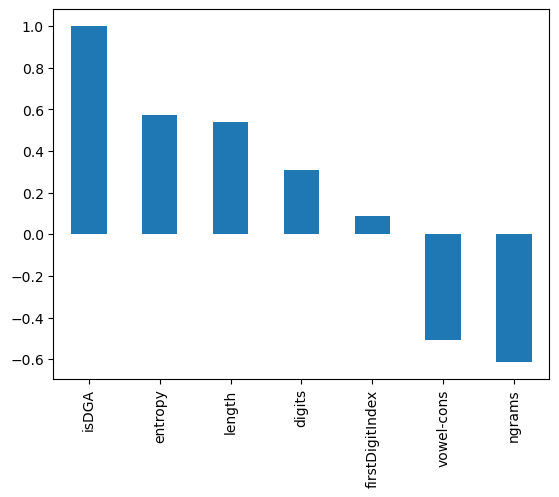

In [19]:
# visualize
corr_results.plot(kind='bar');

Now we want to know how the features are correlated with each other as well as the target. A good way to visualize this is with a heatmap. 

First, let's compute the correlations between all the features and target. Then we will use seaborn to plot these results as a heatmap. 

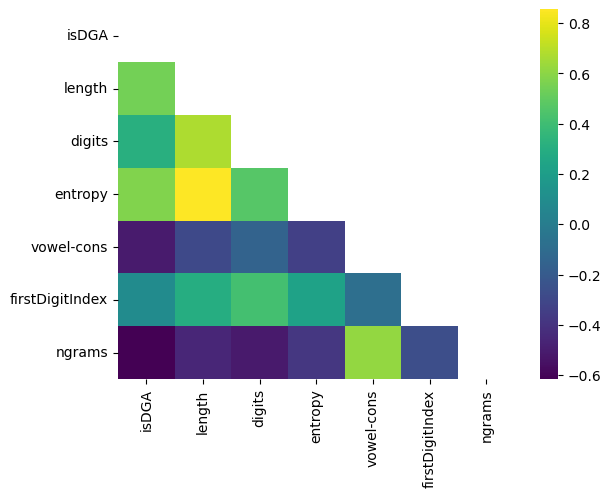

In [20]:
corr_mat = df_final_int.corr()

# visualization
# Generate a mask for the upper triangle (b/c it contains the same information as the lower one. 
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
sns.heatmap(corr_mat, mask=mask, cmap='viridis');

Now let's use a Seaborn pairplot as well.  This will really show you which features have clear dividing lines between the classes.  Docs are available here: http://seaborn.pydata.org/generated/seaborn.pairplot.html

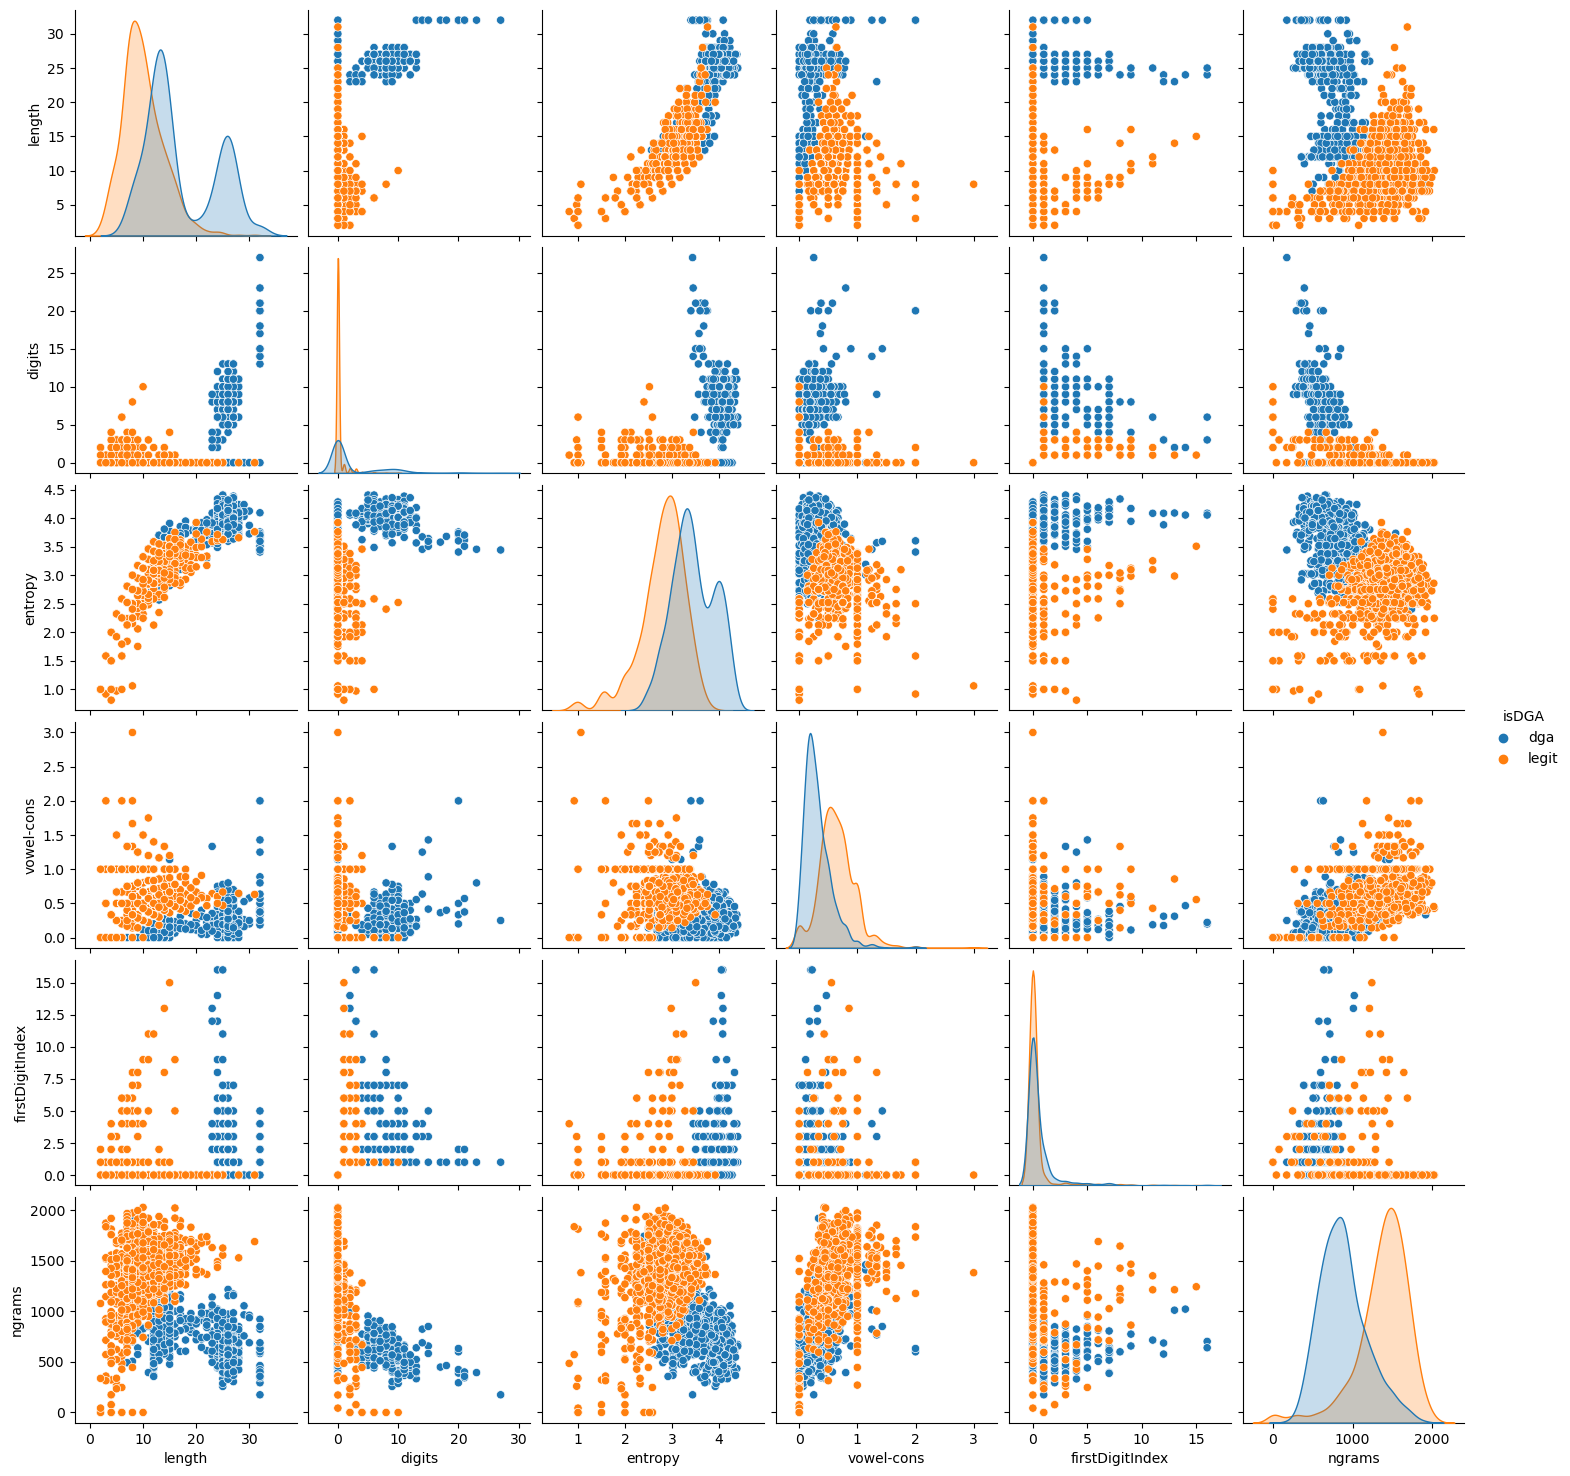

In [21]:
sns.pairplot(df_final, hue='isDGA');

Finally, let's try making a RadViz of the features.  This visualization will help us see whether there is too much noise to make accurate classifications. 

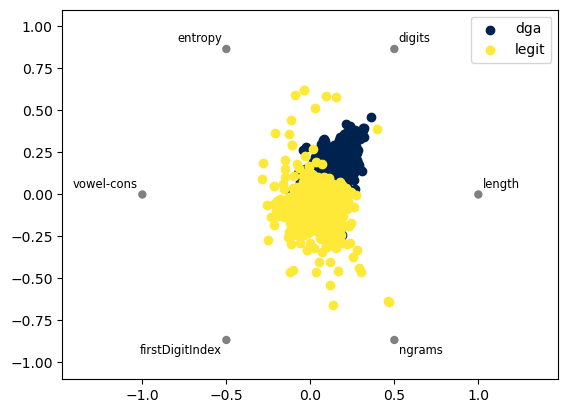

In [22]:
pd.plotting.radviz(df_final, 'isDGA', colormap='cividis');#colormap='Set3'

## Pandas Profiling
You've seen how to do all these steps manually. In our final example for data exploration and feature engineering, you will use a new module called Pandas Profiling to explore your data.  This module will generate much of the same information but it is a major time saver in that it will do all these calculations for you in one command.  

Basic usage is:

```python
profile = ProfileReport(df_final, title='Pandas Profiling Report')
profile
```

In the cell below, execute this command and take a look at the report which is generated to see if you can find any insights about the features we've generated.  After looking at all this, do you think these features will be good enough?


Documentation is available here: https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/getting_started.html

In [ ]:
!pip install ydata-profiling

In [ ]:
profile = ProfileReport(df_final, title='DGA Feature Profiling Report')
profile

## Congrats!
Congrats!  You've now extracted features from the dataset and are ready to begin creating some supervised models!